# CNN Using Keras and MADlib

E2E classification example using MADlib calling a Keras CNN.  Based on model architecture in https://keras.io/examples/cifar10_cnn/

## Table of contents
<a href="#import_libraries">1. Import libraries</a>

<a href="#load_and_prepare_data">2. Load dataset into table</a>

<a href="#image_preproc">3. Call image preprocessor</a>

<a href="#define_and_load_model">4. Define and load model architecture</a>

<a href="#train">5. Train</a>

<a href="#plot">6. Plots by iteration and time</a>

In [1]:
%load_ext sql

/Users/fmcquillan/anaconda/lib/python2.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/Users/fmcquillan/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [2]:
# Greenplum Database 5.x on GCP for deep learning (PM demo machine)
%sql postgresql://gpadmin@35.239.240.26:5432/madlib
        
# Greenplum Database 5.x on GCP (dev machine)
#%sql postgresql://gpadmin@35.247.88.252:5432/cifar10
        
# PostgreSQL local
#%sql postgresql://fmcquillan@localhost:5432/madlib

u'Connected: gpadmin@cifar10'

In [7]:
%sql select madlib.version();
#%sql select version();

1 rows affected.


version
"PostgreSQL 8.3.23 (Greenplum Database 5.7.0 build commit:f7c6eb5cc61b25a7ff9c5a657d6f903befbae013) on x86_64-pc-linux-gnu, compiled by GCC gcc (GCC) 6.2.0, 64-bit compiled on Mar 30 2018 14:19:06"


<a id="import_libraries"></a>
# 1.  Import libraries
From https://keras.io/examples/mnist_transfer_cnn/ import libraries and define some params

In [8]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

batch_size = 32
num_classes = 10
epochs = 100

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


Others needed in this workbook

In [9]:
import pandas as pd
import numpy as np
import sys
import os
from matplotlib import pyplot as plt

<a id="load_and_prepare_data"></a>
# 2.  Set up image loader and load dataset into table

First set up image loader.

In [10]:
madlib_site_dir = '/Users/fmcquillan/Documents/Product/MADlib/Demos/data'
sys.path.append(madlib_site_dir)

# Import image loader module
from madlib_image_loader import ImageLoader, DbCredentials

# Specify database credentials, for connecting to db
db_creds = DbCredentials(user='gpadmin',
                         host='35.239.240.26',
                         port='5432',
                         password='')

# Specify database credentials, for connecting to db
#db_creds = DbCredentials(user='gpadmin', 
#                         db_name='cifar10',
#                         host='35.247.88.252',
#                         port='5432',
#                         password='')

# Initialize ImageLoader (increase num_workers to run faster)
iloader = ImageLoader(num_workers=5, db_creds=db_creds)

First load CIFAR-10 data from Keras consisting of 50,000 32x32 color training images, labeled over 10 categories, and 10,000 test images.

In [11]:
# Load dataset into np array
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#%sql DROP TABLE IF EXISTS cifar_10_train_data, cifar_10_test_data;

# Save images to temporary directories and load into database
iloader.load_np_array_to_table(x_train, y_train, 'cifar_10_train_data', append=False, img_names=None)
iloader.load_np_array_to_table(x_test, y_test, 'cifar_10_test_data', append=False, img_names=None)

MainProcess: Connected to cifar10 db.
Executing: CREATE TABLE cifar_10_train_data (id SERIAL, x REAL[], y TEXT)
CREATE TABLE
Created table cifar_10_train_data in cifar10 db
Spawning 5 workers...
Initializing PoolWorker-1 [pid 38560]
PoolWorker-1: Created temporary directory PoolWorker-1
Initializing PoolWorker-2 [pid 38561]
PoolWorker-2: Created temporary directory PoolWorker-2
Initializing PoolWorker-3 [pid 38562]
PoolWorker-3: Created temporary directory PoolWorker-3
Initializing PoolWorker-4 [pid 38563]
PoolWorker-4: Created temporary directory PoolWorker-4
Initializing PoolWorker-5 [pid 38564]
PoolWorker-5: Created temporary directory PoolWorker-5
PoolWorker-1: Connected to cifar10 db.
PoolWorker-2: Connected to cifar10 db.
PoolWorker-3: Connected to cifar10 db.
PoolWorker-4: Connected to cifar10 db.
PoolWorker-5: Connected to cifar10 db.
PoolWorker-1: Wrote 1000 images to /tmp/madlib_ASclSSNtOB/cifar_10_train_data0000.tmp
PoolWorker-2: Wrote 1000 images to /tmp/madlib_va8z5K5H7g/c

PoolWorker-1: Removed temporary directory PoolWorker-1
PoolWorker-3: Removed temporary directory PoolWorker-3
Done!  Loaded 50000 images in 48.6765198708s
MainProcess: Connected to cifar10 db.
Executing: CREATE TABLE cifar_10_test_data (id SERIAL, x REAL[], y TEXT)
CREATE TABLE
Created table cifar_10_test_data in cifar10 db
Spawning 5 workers...
Initializing PoolWorker-6 [pid 38571]
PoolWorker-6: Created temporary directory PoolWorker-6
Initializing PoolWorker-7 [pid 38572]
PoolWorker-7: Created temporary directory PoolWorker-7
Initializing PoolWorker-8 [pid 38573]
PoolWorker-8: Created temporary directory PoolWorker-8
Initializing PoolWorker-9 [pid 38574]
PoolWorker-9: Created temporary directory PoolWorker-9
Initializing PoolWorker-10 [pid 38575]
PoolWorker-10: Created temporary directory PoolWorker-10
PoolWorker-6: Connected to cifar10 db.
PoolWorker-7: Connected to cifar10 db.
PoolWorker-8: Connected to cifar10 db.
PoolWorker-9: Connected to cifar10 db.
PoolWorker-10: Connected to 

In [14]:
%sql select count(*) from cifar_10_train_data;

1 rows affected.


count
50000


<a id="image_preproc"></a>
# 3. Call image preprocessor

Transforms from one image per row to multiple images per row for batch optimization.  Also normalizes and one-hot encodes.

Training data

In [10]:
%%sql
DROP TABLE IF EXISTS cifar_10_train_data_packed, cifar_10_train_data_packed_summary;

SELECT madlib.training_preprocessor_dl('cifar_10_train_data',        -- Source table
                                       'cifar_10_train_data_packed', -- Output table
                                       'y',                          -- Dependent variable
                                       'x',                          -- Independent variable
                                        1000,                        -- Buffer size
                                        255                          -- Normalizing constant
                                        );

SELECT * FROM cifar_10_train_data_packed_summary;

Done.
1 rows affected.
1 rows affected.


source_table,output_table,dependent_varname,independent_varname,dependent_vartype,class_values,buffer_size,normalizing_const,num_classes
cifar_10_train_data,cifar_10_train_data_packed,y,x,text,"[u'0', u'1', u'2', u'3', u'4', u'5', u'6', u'7', u'8', u'9']",24415,255.0,10


Test data

In [11]:
%%sql
DROP TABLE IF EXISTS cifar_10_test_data_packed, cifar_10_test_data_packed_summary;

SELECT madlib.validation_preprocessor_dl('cifar_10_test_data',          -- Source table
                                         'cifar_10_test_data_packed',   -- Output table
                                         'y',                           -- Dependent variable
                                         'x',                           -- Independent variable
                                         'cifar_10_train_data_packed',  -- Training preproc table
                                         1000                           -- Buffer size
                                        );

SELECT * FROM cifar_10_test_data_packed_summary;

Done.
1 rows affected.
1 rows affected.


source_table,output_table,dependent_varname,independent_varname,dependent_vartype,class_values,buffer_size,normalizing_const,num_classes
cifar_10_test_data,cifar_10_test_data_packed,y,x,text,"[u'0', u'1', u'2', u'3', u'4', u'5', u'6', u'7', u'8', u'9']",5000,255.0,10


<a id="define_and_load_model"></a>
# 4. Define and load model architecture

Model architecture from https://keras.io/examples/cifar10_cnn/

In [12]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
__________

Load into model architecture table using psycopg2

In [13]:
import psycopg2 as p2
conn = p2.connect('postgresql://gpadmin@35.239.240.26:5432/madlib')
cur = conn.cursor()

%sql DROP TABLE IF EXISTS model_arch_library;
query = "SELECT madlib.load_keras_model('model_arch_library', %s, NULL, %s)"
cur.execute(query,[model.to_json(), "CNN from Keras docs for CIFAR-10"])
conn.commit()

# check model loaded OK
%sql SELECT model_id, name FROM model_arch_library;

Done.
1 rows affected.


model_id,name
1,CNN from Keras docs for CIFAR-10


<a id="train"></a>
# 5.  Train

In [22]:
%%sql
DROP TABLE IF EXISTS cifar_10_model, cifar_10_model_summary;

SELECT madlib.madlib_keras_fit('cifar_10_train_data_packed',    -- source table
                               'cifar_10_model',                -- model output table
                               'model_arch_library',            -- model arch table
                                1,                              -- model arch id
                                $$ loss='categorical_crossentropy', optimizer='rmsprop(lr=0.0001, decay=1e-6)', metrics=['accuracy']$$,  -- compile_params
                                $$ batch_size=32, epochs=3 $$,  -- fit_params
                                20,                             -- num_iterations
                                0,                              -- GPUs per host
                                'cifar_10_test_data_packed',    -- validation dataset
                                2                               -- metrics compute frequency
                              );

Done.
1 rows affected.


madlib_keras_fit
""


View the model summary:

In [110]:
%%sql
SELECT * FROM cifar_10_model_summary;

1 rows affected.


source_table,model,dependent_varname,independent_varname,model_arch_table,model_arch_id,compile_params,fit_params,num_iterations,validation_table,metrics_compute_frequency,name,description,model_type,model_size,start_training_time,end_training_time,metrics_elapsed_time,madlib_version,num_classes,class_values,dependent_vartype,normalizing_const,metrics_type,training_metrics_final,training_loss_final,training_metrics,training_loss,validation_metrics_final,validation_loss_final,validation_metrics,validation_loss,metrics_iters
cifar_10_train_data_packed,cifar_10_model,y,x,model_arch_library,1,"loss='categorical_crossentropy', optimizer='rmsprop(lr=0.0001, decay=1e-6)', metrics=['accuracy']","batch_size=32, epochs=3",20,cifar_10_test_data_packed,2,None,None,madlib_keras,4886.20019531,2019-06-25 05:40:29.287703,2019-06-25 07:59:52.961506,"[798.95044708252, 1616.68976902962, 2447.13853096962, 3273.68762302399, 4116.44566893578, 4962.07483291626, 5805.66080999374, 6665.33687210083, 7526.0603749752, 8363.67366909981]",1.16-dev,10,"[u'0', u'1', u'2', u'3', u'4', u'5', u'6', u'7', u'8', u'9']",text,255.0,[u'accuracy'],0.836480021477,0.500134825706,"[0.579240024089813, 0.672980010509491, 0.723999977111816, 0.75764000415802, 0.783959984779358, 0.79475998878479, 0.811240017414093, 0.822780013084412, 0.829559981822968, 0.836480021476746]","[1.19081699848175, 0.940543830394745, 0.800645172595978, 0.700933694839478, 0.636690974235535, 0.599389910697937, 0.556614756584167, 0.53840559720993, 0.517430067062378, 0.500134825706482]",0.778900027275,0.661625564098,"[0.57150000333786, 0.653800010681152, 0.692200005054474, 0.721300005912781, 0.740000009536743, 0.751299977302551, 0.756099998950958, 0.769999980926514, 0.77240002155304, 0.778900027275085]","[1.20945084095001, 0.987037718296051, 0.871006071567535, 0.800125658512115, 0.751632690429688, 0.72808450460434, 0.704570233821869, 0.684175074100494, 0.675221920013428, 0.661625564098358]","[2, 4, 6, 8, 10, 12, 14, 16, 18, 20]"


Evaluate using test data (same values as last iteration from the fit output summary above).

In [8]:
%%sql
DROP TABLE IF EXISTS cifar10_validate;

SELECT madlib.madlib_keras_evaluate('cifar_10_model',               -- model
                                    'cifar_10_test_data_packed',   -- test table
                                    'cifar10_validate'             -- output table
                                    );

SELECT * FROM cifar10_validate;

Done.
1 rows affected.
1 rows affected.


loss,metric,metrics_type
0.661625564098,0.778900027275,[u'accuracy']


<a id="plot"></a>
# 6.  Plots by iteration and by time
Accuracy by iteration

1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.


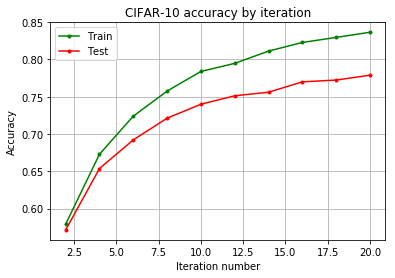

In [100]:
# get accuracy and iteration number
iters_proxy = %sql SELECT metrics_iters FROM cifar_10_model_summary;
train_accuracy_proxy = %sql SELECT training_metrics FROM cifar_10_model_summary;
test_accuracy_proxy = %sql SELECT validation_metrics FROM cifar_10_model_summary;

# get number of points
num_points_proxy = %sql SELECT array_length(metrics_iters,1) FROM cifar_10_model_summary;
num_points = num_points_proxy[0]

# reshape to np arrays
iters = np.array(iters_proxy).reshape(num_points)
train_accuracy = np.array(train_accuracy_proxy).reshape(num_points)
test_accuracy = np.array(test_accuracy_proxy).reshape(num_points)

#plot
plt.title('CIFAR-10 accuracy by iteration')
plt.xlabel('Iteration number')
plt.ylabel('Accuracy')
plt.grid(True)
plt.plot(iters, train_accuracy, 'g.-', label='Train')
plt.plot(iters, test_accuracy, 'r.-', label='Test')
plt.legend()

Loss by iteration

1 rows affected.
1 rows affected.


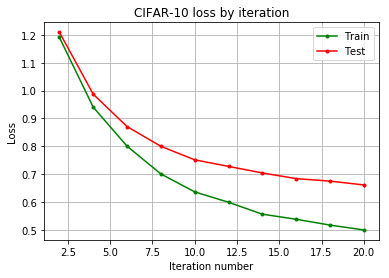

In [101]:
# get loss
train_loss_proxy = %sql SELECT training_loss FROM cifar_10_model_summary;
test_loss_proxy = %sql SELECT validation_loss FROM cifar_10_model_summary;

# reshape to np arrays
train_loss = np.array(train_loss_proxy).reshape(num_points)
test_loss = np.array(test_loss_proxy).reshape(num_points)

#plot
plt.title('CIFAR-10 loss by iteration')
plt.xlabel('Iteration number')
plt.ylabel('Loss')
plt.grid(True)
plt.plot(iters, train_loss, 'g.-', label='Train')
plt.plot(iters, test_loss, 'r.-', label='Test')
plt.legend()

Accuracy by time

1 rows affected.


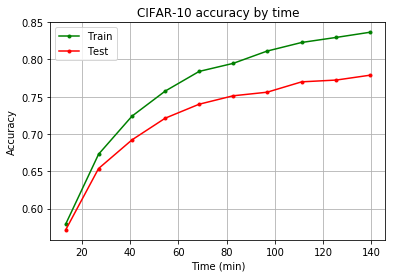

In [108]:
# get time
time_proxy = %sql SELECT metrics_elapsed_time FROM cifar_10_model_summary;

# reshape to np arrays
time = np.array(time_proxy).reshape(num_points)/60.0

#plot
plt.title('CIFAR-10 accuracy by time')
plt.xlabel('Time (min)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.plot(time, train_accuracy, 'g.-', label='Train')
plt.plot(time, test_accuracy, 'r.-', label='Test')
plt.legend()

Time to achieve a given accuracy

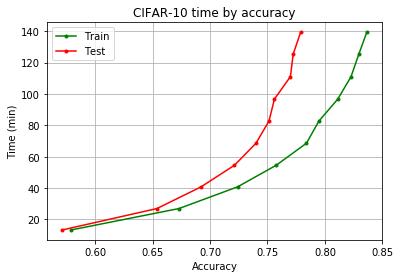

In [109]:
#plot
plt.title('CIFAR-10 time by accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Time (min)')
plt.grid(True)
plt.plot(train_accuracy, time, 'g.-', label='Train')
plt.plot(test_accuracy, time, 'r.-', label='Test')
plt.legend()